# ABM - OT comparison

Let's import `ot` which is POT (Python Optimal Transport) and the local ABM to compare against, here called `sx`.

In [13]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pytest
import ot
import ot.plot
import pyflamegpu

from sx import make_simulation, C
import util


def plot_cost(M):
    plt.figure(2)
    plt.imshow(M, interpolation="nearest")
    plt.title(f"Cost matrix M")


def plot_ot(xs, xt, G, what):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)
    plt.imshow(G, interpolation="nearest")
    plt.title(f"OT matrix: {what}")
    plt.subplot(1, 2, 2)
    ot.plot.plot2D_samples_mat(xs, xt, G, color=[0.5, 0.5, 1])
    plt.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples")
    plt.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples")
    plt.legend(loc=0)
    plt.title(f"OT matrix: {what} with samples")
    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()


def generate_distributions(s=50, t=50):
    mu_s = np.array([4, 4])
    cov_s = np.array([[1, 0], [0, 1]])
    mu_t = np.array([8, 8])
    cov_t = np.array([[1, -0.8], [-0.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(s, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(t, mu_t, cov_t)
    xs[xs < 0] *= -1
    xt[xt < 0] *= -1
    scale = 5
    xs *= scale
    xt *= scale
    return np.round(xs).astype("int"), np.round(xt).astype("int")

## OT Solution

a='[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]', b='[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]'
sinkhorn:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


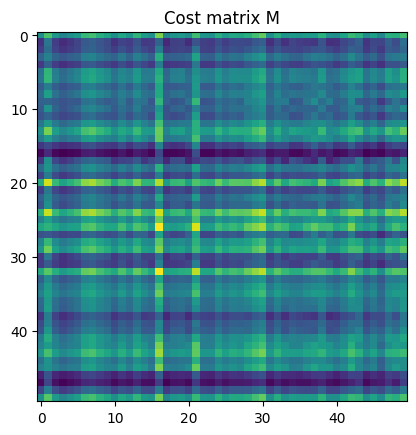

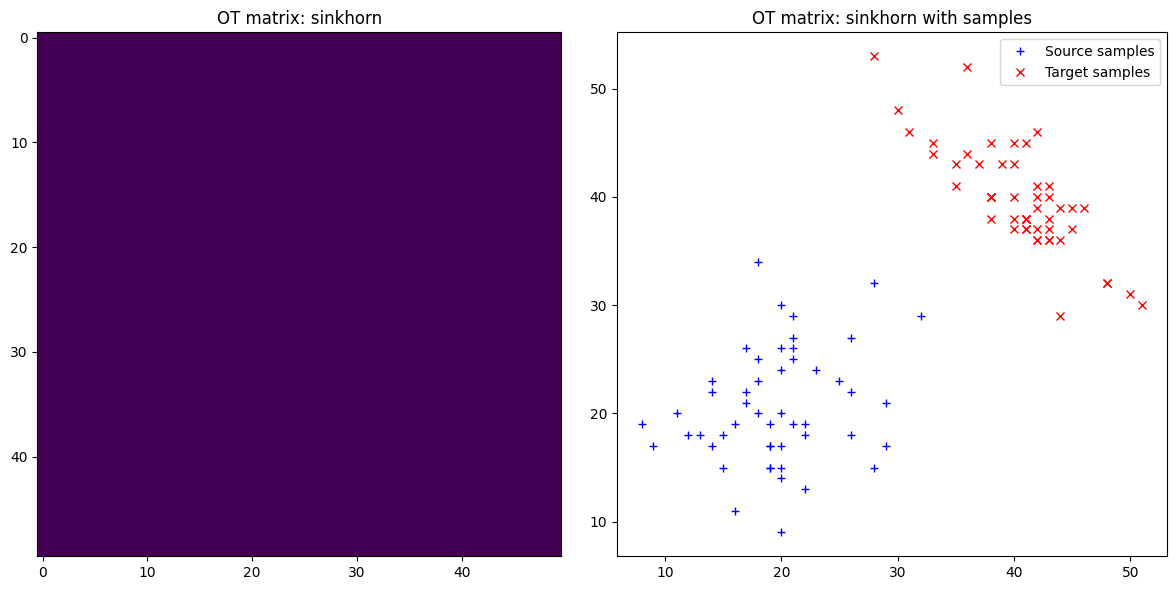

EMD:
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.02 0.   0.   ... 0.   0.   0.  ]]


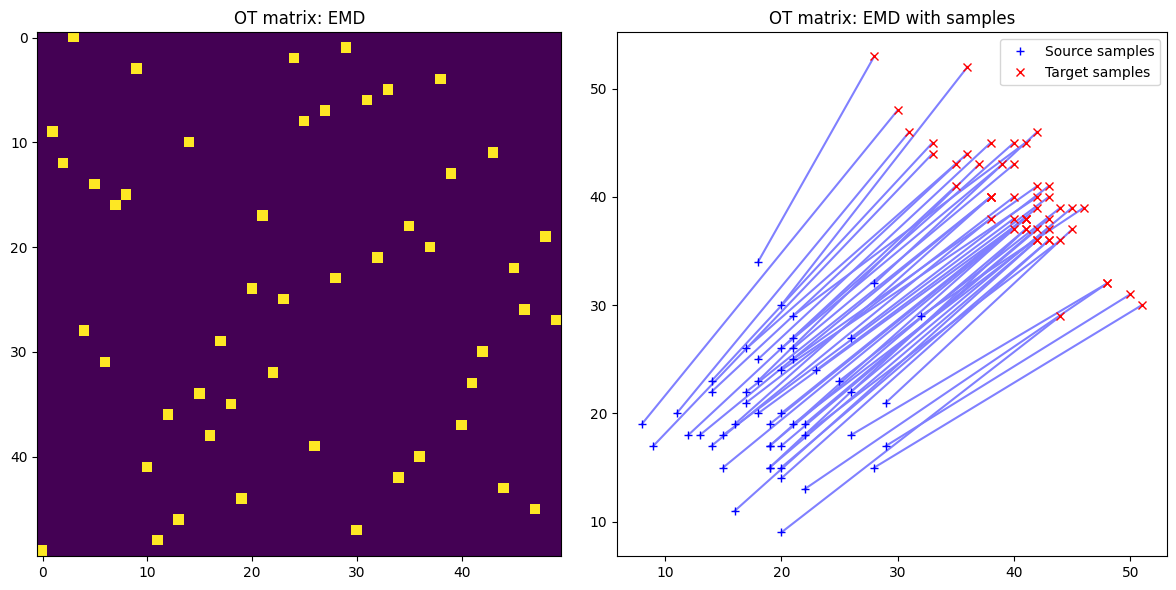

In [14]:
# pos_source, pos_target = np.array([[5, 0], [0, 5]]), np.array([[14, 15], [15, 14]])
pos_source, pos_target = generate_distributions()

# OT solution:
M_loss = ot.dist(pos_source, pos_target)
plot_cost(M_loss)
n, m = len(pos_source), len(pos_target)
a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples
print(f"a='{a}', b='{b}'")

# sinkhorn: doesn't work for this case: numerical errors!
regularization = 1e-1
exp_shinkhorn = ot.sinkhorn(a, b, M_loss, regularization)
print(f"sinkhorn:\n{exp_shinkhorn}")
plot_ot(pos_source, pos_target, exp_shinkhorn, "sinkhorn")

# EMD -- Earth Movers Distance - works fine
exp = ot.emd(a, b, M_loss)
print(f"EMD:\n{exp}")
plot_ot(pos_source, pos_target, exp, "EMD")

## ABM solution

[99] humans=53
[199] humans=53
[299] humans=53
[399] humans=53
[499] humans=44
[599] humans=36
[699] humans=36
[799] humans=31
[899] humans=5
[WARNING] All humans are dead. Simulation stops early.


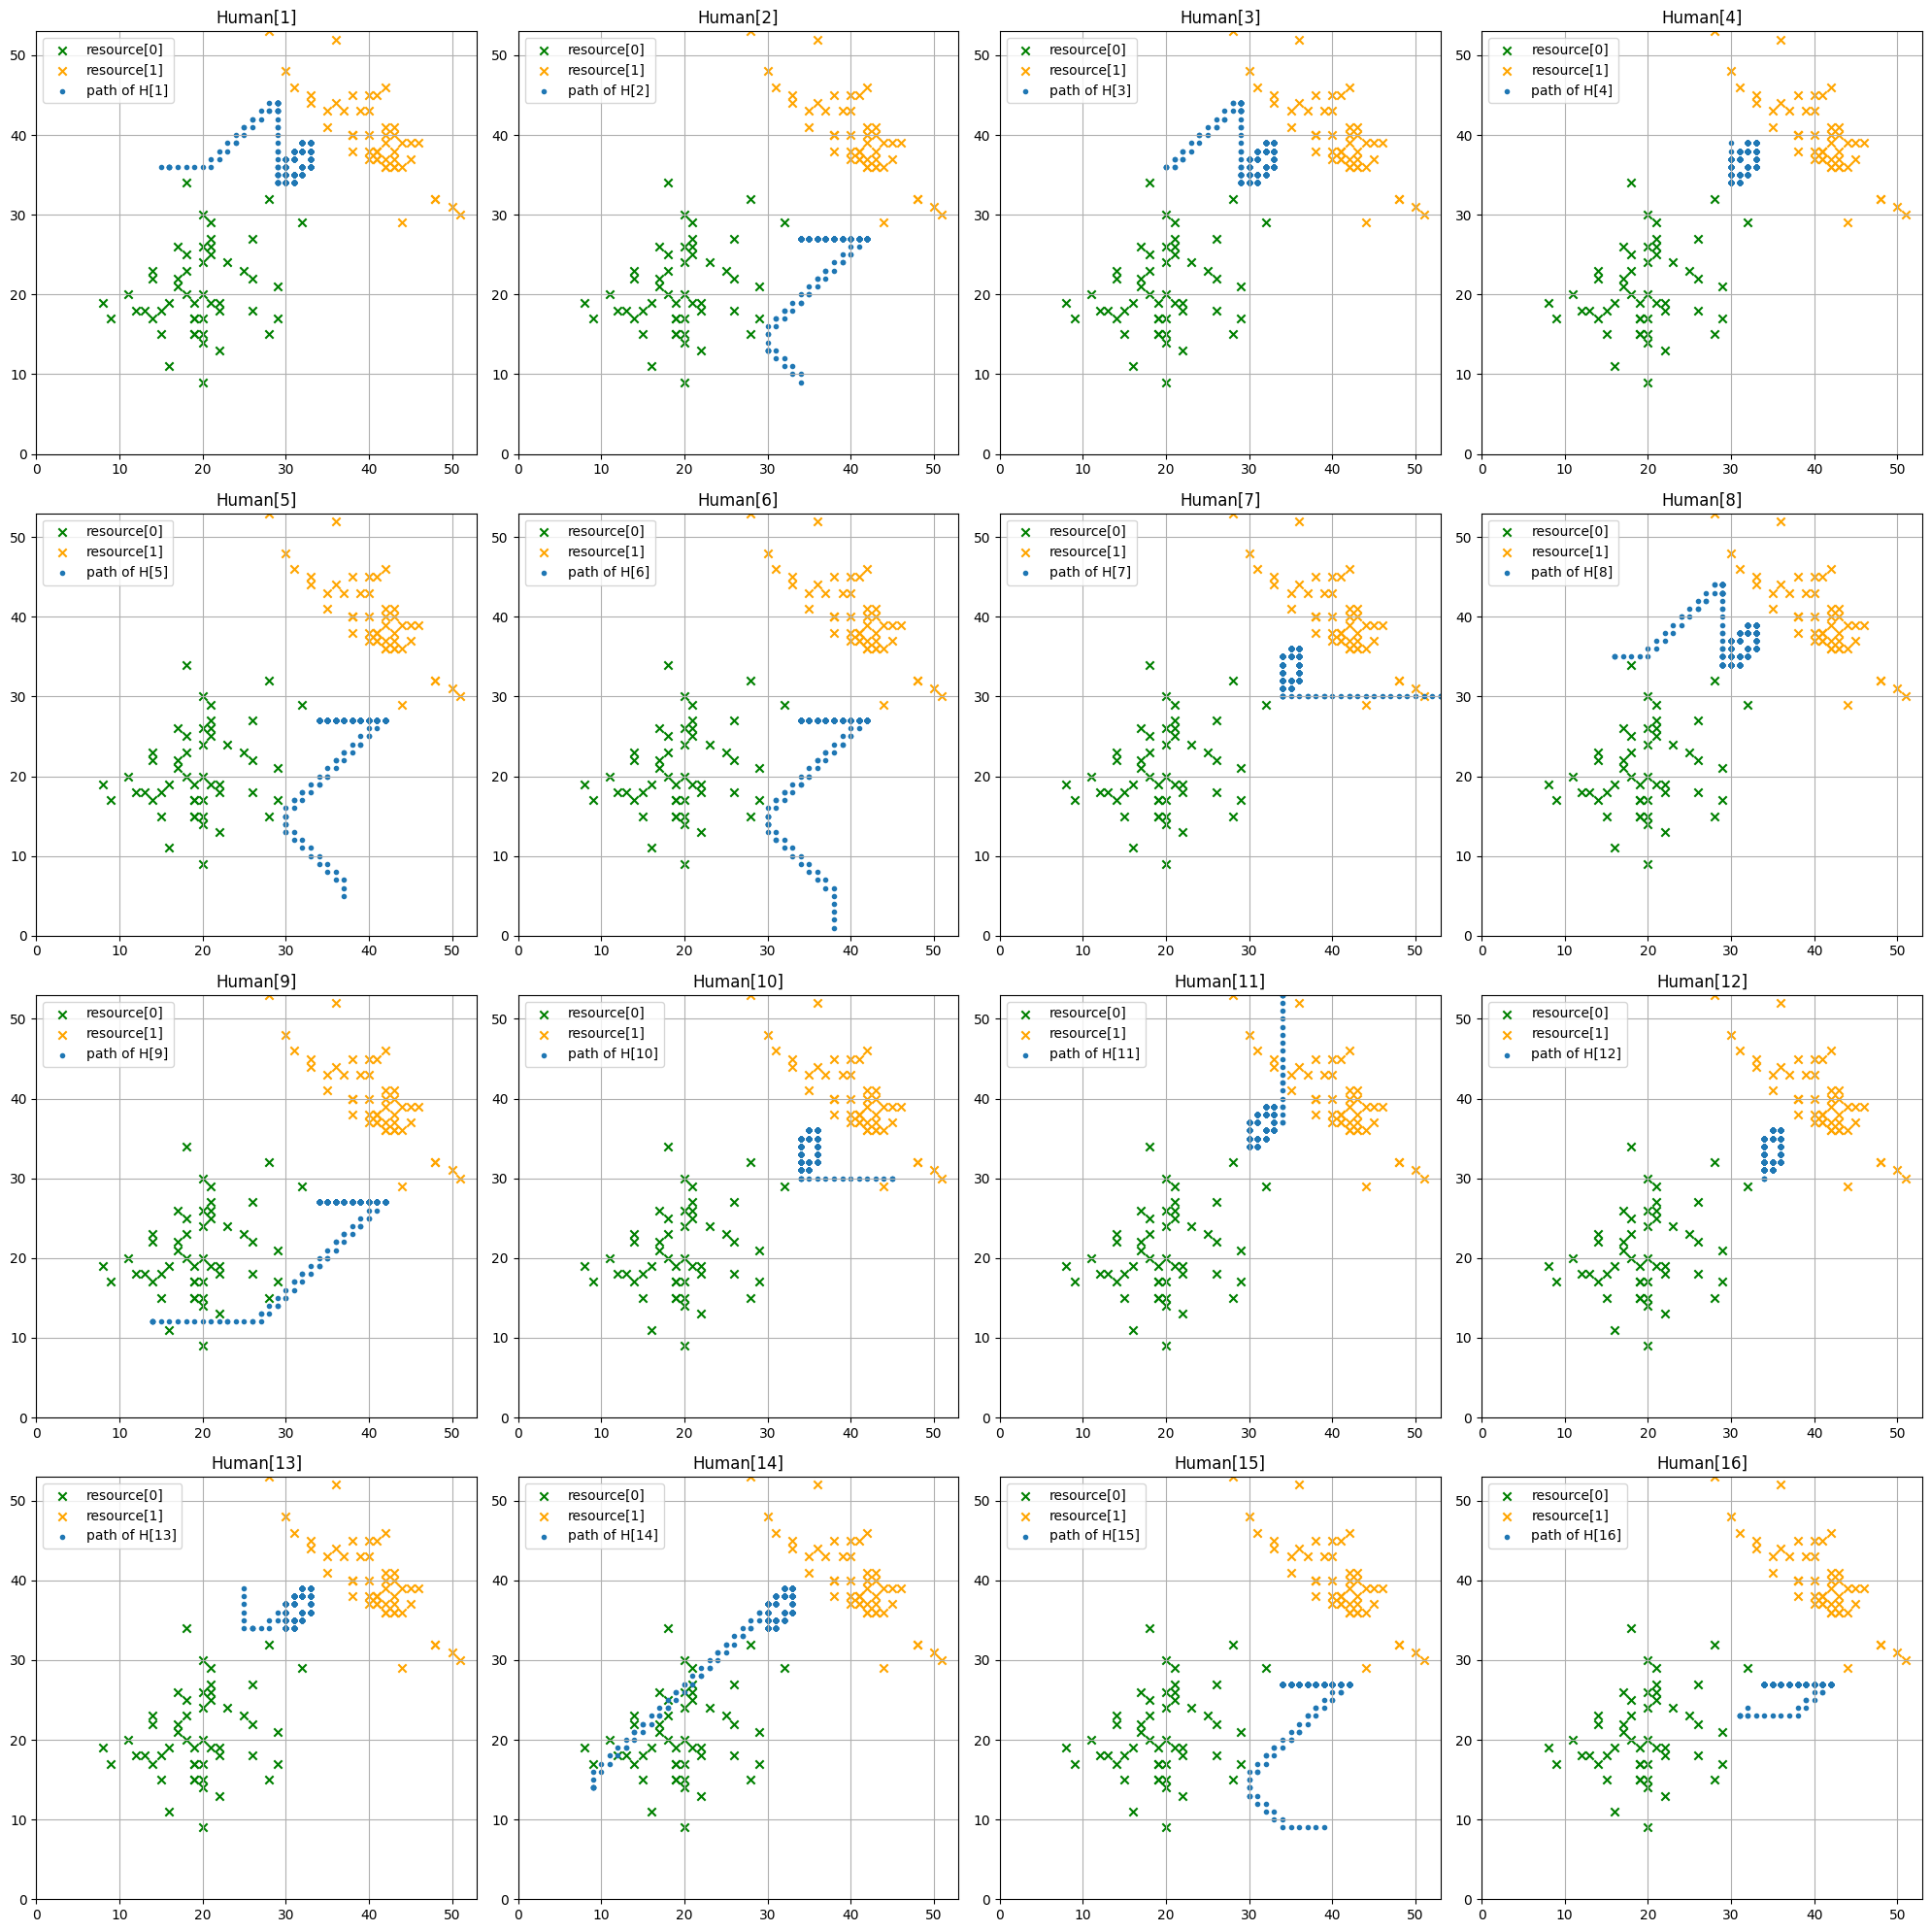

got:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
exp:
 [[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.02 0.   0.   ... 0.   0.   0.  ]]


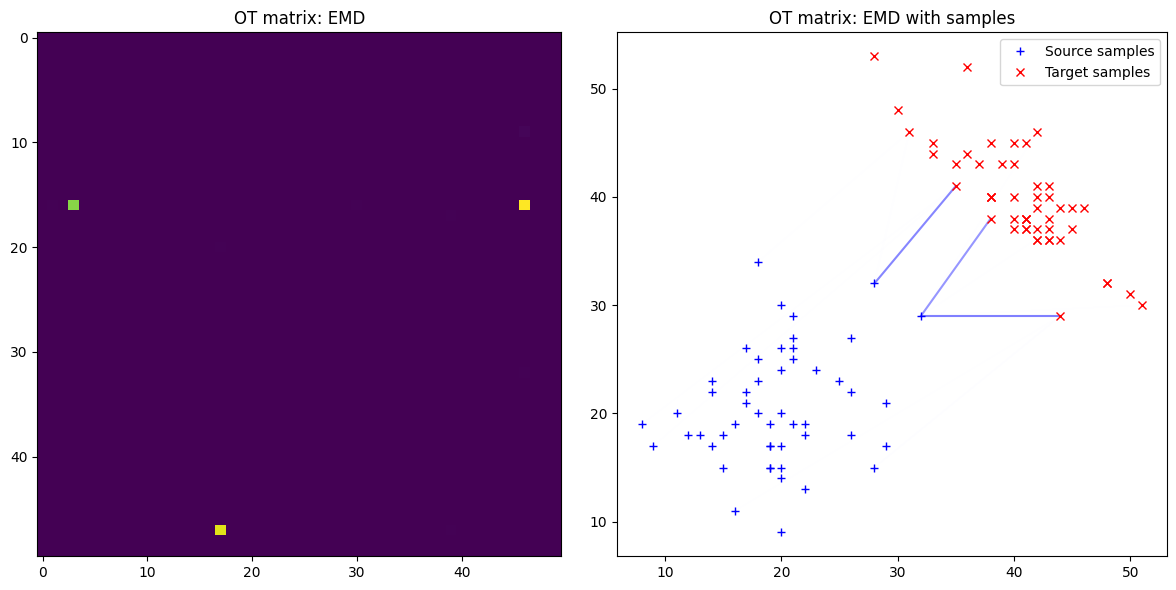

In [18]:
seed = 3
random.seed(seed)
grid_size = int(np.max([pos_source, pos_target]))
n_humans = int(grid_size)
steps = 1000


def random_location(grid_size):
    return random.randint(0, grid_size), random.randint(0, grid_size)


model, simulation, ctx = make_simulation(grid_size=grid_size)
simulation.SimulationConfig().random_seed = seed
resources = pyflamegpu.AgentVector(ctx.resource, len(pos_source) + len(pos_target))
for i, p in enumerate(pos_source):
    resources[i].setVariableInt("x", int(p[0]))
    resources[i].setVariableInt("y", int(p[1]))
    resources[i].setVariableInt("type", 0)
for i, p in enumerate(pos_target):
    resources[i + len(pos_source)].setVariableInt("x", int(p[0]))
    resources[i + len(pos_source)].setVariableInt("y", int(p[1]))
    resources[i + len(pos_source)].setVariableInt("type", 1)
humans = pyflamegpu.AgentVector(ctx.human, n_humans)
for human in humans:
    human.setVariableInt("x", random.randint(0, grid_size))
    human.setVariableInt("y", random.randint(0, grid_size))
    human.setVariableArrayInt("resources", (2, 2))
    human.setVariableFloat("actionpotential", C.AP_DEFAULT)
for av in [resources, humans]:
    simulation.setPopulationData(av)
paths = []
collected_resources = []
for step in range(steps):
    simulation.step()
    simulation.getPopulationData(humans)
    if len(humans) == 0:
        print("[WARNING] All humans are dead. Simulation stops early.")
        break
    if step % (steps / 10) == (steps / 10) - 1:
        print(f"[{step}] humans={len(humans)}")
    for human in humans:
        id = human.getID()
        x, y = human.getVariableInt("x"), human.getVariableInt("y")
        paths.append([id, x, y])
        loc = human.getVariableArrayInt("ana_last_resource_location")
        if loc != (-1, -1):
            collected_resources.append([id, *loc])
# print(collected_resources)
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()
paths = np.array(paths)
for i, id in enumerate(set(paths[:, 0])):
    if i == 16:
        break  # only size for 16 humans in this grid
    path = paths[paths[:, 0] == id][:, 1:3]
    x = path[:, 0]
    y = path[:, 1]
    ax = axs[i]
    ax.scatter(
        pos_source[:, 0],
        pos_source[:, 1],
        color="green",
        marker="x",
        label="resource[0]",
    )
    ax.scatter(
        pos_target[:, 0],
        pos_target[:, 1],
        color="orange",
        marker="x",
        label="resource[1]",
    )
    ax.scatter(x, y, marker=".", label=f"path of H[{id}]")
    ax.set_title(f"Human[{id}]")
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

got = util.collected_resource_list_to_cost_matrix(
    collected_resources, pos_source, pos_target
)
print("got:\n", got)
print("exp:\n", exp)

plot_ot(pos_source, pos_target, got, "EMD")